## Traveling Salesman Problems

One of the most studied scheduling problems is TSP (traveling salesman problem).
TSP tries to identify a shortest (or fastest) route that visits N cities exactly once, and eventually returns to the starting point. The distance between cities can be regarded as cost or weight of travel $w_{ij}$. 
For a symmetrical N-city TSP ($w_{ij}$=$w_{ji}$) there are $(N-1)!/2$ possible routes assuming the travel starts at a given city, thus the complexity of TSP grows exponentially with the number of cities to visit (TSP is classified as NP-hard problem).

(see also <a href="https://www.math.uwaterloo.ca/tsp/">www.math.uwaterloo.ca/tsp</a>, in particular <a href="https://nbviewer.org/url/norvig.com/ipython/TSP.ipynb">python tutorial</a> by Peter Norvig).

We want to minimize the distance ("cost function") and (for now) we don't care about what is the last city to visit.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qaoa_utilities import *
from qaoa_classical_solvers import *

# provide seed (crucial for reproducibility, debugging)
seed = 1686421
np.random.seed(seed)
random.seed(seed)


[[  0.         108.63256126  87.62039032  24.21819563  67.91392063]
 [108.63256126   0.          59.83421851 118.61493568  83.30137446]
 [ 87.62039032  59.83421851   0.          84.76347562  29.81970051]
 [ 24.21819563 118.61493568  84.76347562   0.          59.02926133]
 [ 67.91392063  83.30137446  29.81970051  59.02926133   0.        ]]


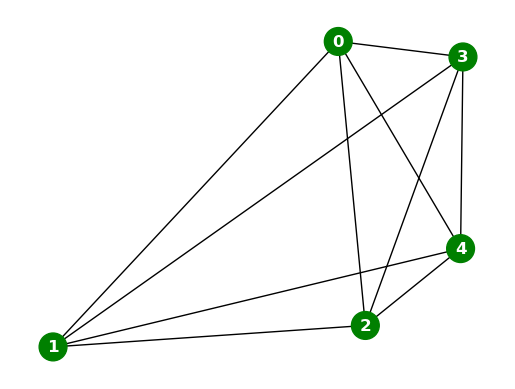

In [2]:
# simple example: cities at random position
N = 5
# random numbers are <1.0, default scale=10, here increase it a bit
gr = create_graph(nodes=N, seed=seed, scale=100)
print(get_weight_matrix(gr))
plot_graph(gr, colors="green")

### Classical solution

Number of cities: 5; number of permutations: 120  (24 to check)
Best route: [0, 3, 4, 2, 1]   (cost: 172.901)
[0, 3, 4, 2, 1]


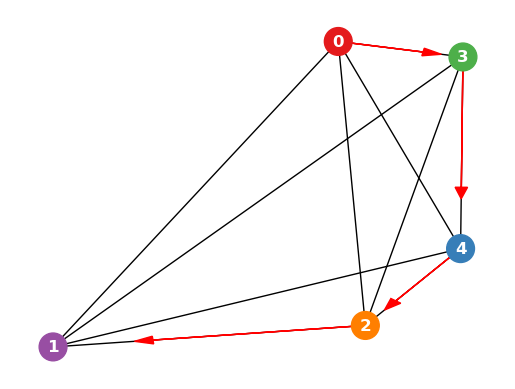

In [3]:
# find best path by checking all combinations
class_solution = tsp_solve_brute_force(gr, starting_city=0, verbose=True)
print(class_solution)
plot_graph(gr, colors=class_solution)

[0, 3, 4, 2, 1]


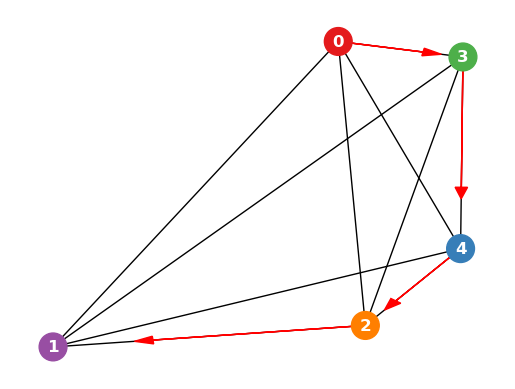

In [4]:
# using simulated annealer
random.seed(seed)
sa = TSP_SimulatedAnnealer(gr, starting_city=0)
sa.anneal()
sa_solution = sa.get_best_solution()
print(sa_solution)
plot_graph(gr, sa_solution)

For 5 cities:
766 µs ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
For 6 cities:
4.53 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
For 7 cities:
30 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
For 8 cities:
247 ms ± 3.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
For 9 cities:
2.31 s ± 40.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


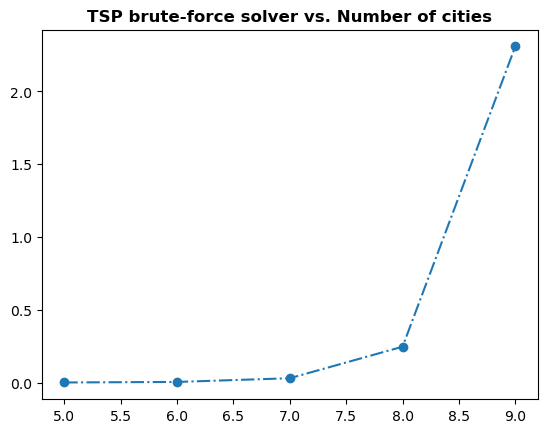

In [5]:
# compute time increases exponentially with number of cities
# average compute time (for 10 runs)
calculation_times = []
city_sizes = list(range(5, 10))

for n in city_sizes:
    print(f"For {n} cities:")
    positions = list(get_position_dict(n, seed=seed).values())
    calc_time = %timeit -o -n 10 tsp_solve_brute_force(positions) 
    calculation_times.append(calc_time.average)

plot_histogram(city_sizes, calculation_times, 
              title="TSP brute-force solver vs. Number of cities",
              fmt='o-.')

[0, 10, 7, 8, 4, 3, 9, 2, 11, 14, 12, 13, 1, 5, 6]


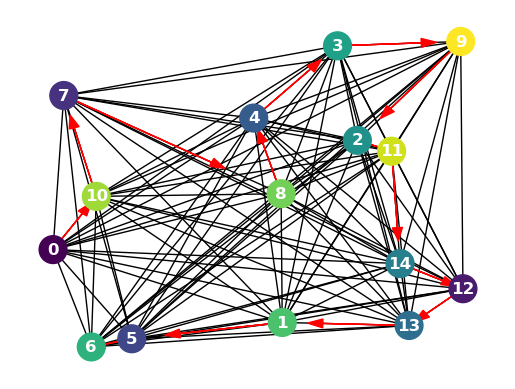

In [6]:
# simulated annealer is still fast for tens of cities
N = 15
gr1 = create_graph(N, scale=100, seed=135792)
sa = TSP_SimulatedAnnealer(gr1, starting_city=0)
sa.anneal()
sa_solution1 = sa.get_best_solution()
print(sa_solution1)
plot_graph(gr1, sa_solution1)

### Using QAOA

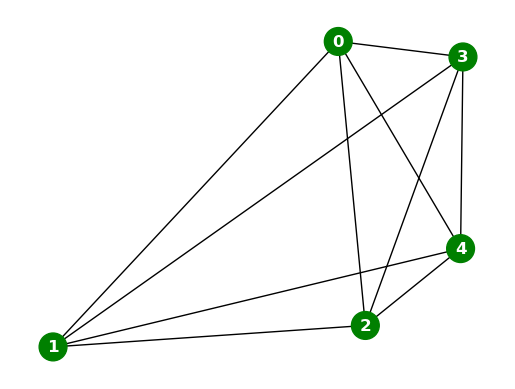

In [3]:
import pennylane as qml
from pennylane import numpy as pnp
from qml_qaoa_utilities import *
from pprint import pprint

plot_graph(gr, colors="green")

{'offset': 19449.1044665211,
 'z_0': -2492.05262629494,
 'z_0*z_1': 593.074678375549,
 'z_0*z_12': 593.074678375549,
 'z_0*z_2': 593.074678375549,
 'z_0*z_3': 593.074678375549,
 'z_0*z_4': 593.074678375549,
 'z_0*z_5': 14.9585546283109,
 'z_0*z_6': 29.6537339187774,
 'z_0*z_7': 20.8253436156374,
 'z_0*z_8': 593.074678375549,
 'z_1': -2444.75470269559,
 'z_1*z_13': 593.074678375549,
 'z_1*z_2': 593.074678375549,
 'z_1*z_3': 593.074678375549,
 'z_1*z_5': 593.074678375549,
 'z_1*z_6': 21.1908689045576,
 'z_1*z_7': 7.45492512829784,
 'z_1*z_9': 593.074678375549,
 'z_10': -2437.90063165821,
 'z_10*z_11': 593.074678375549,
 'z_10*z_14': 593.074678375549,
 'z_10*z_15': 14.7573153326808,
 'z_10*z_2': 593.074678375549,
 'z_10*z_4': 29.6537339187774,
 'z_10*z_5': 21.1908689045576,
 'z_10*z_6': 593.074678375549,
 'z_10*z_8': 593.074678375549,
 'z_10*z_9': 593.074678375549,
 'z_11': -2415.33629757881,
 'z_11*z_15': 593.074678375549,
 'z_11*z_3': 593.074678375549,
 'z_11*z_4': 20.8253436156374,
 'z

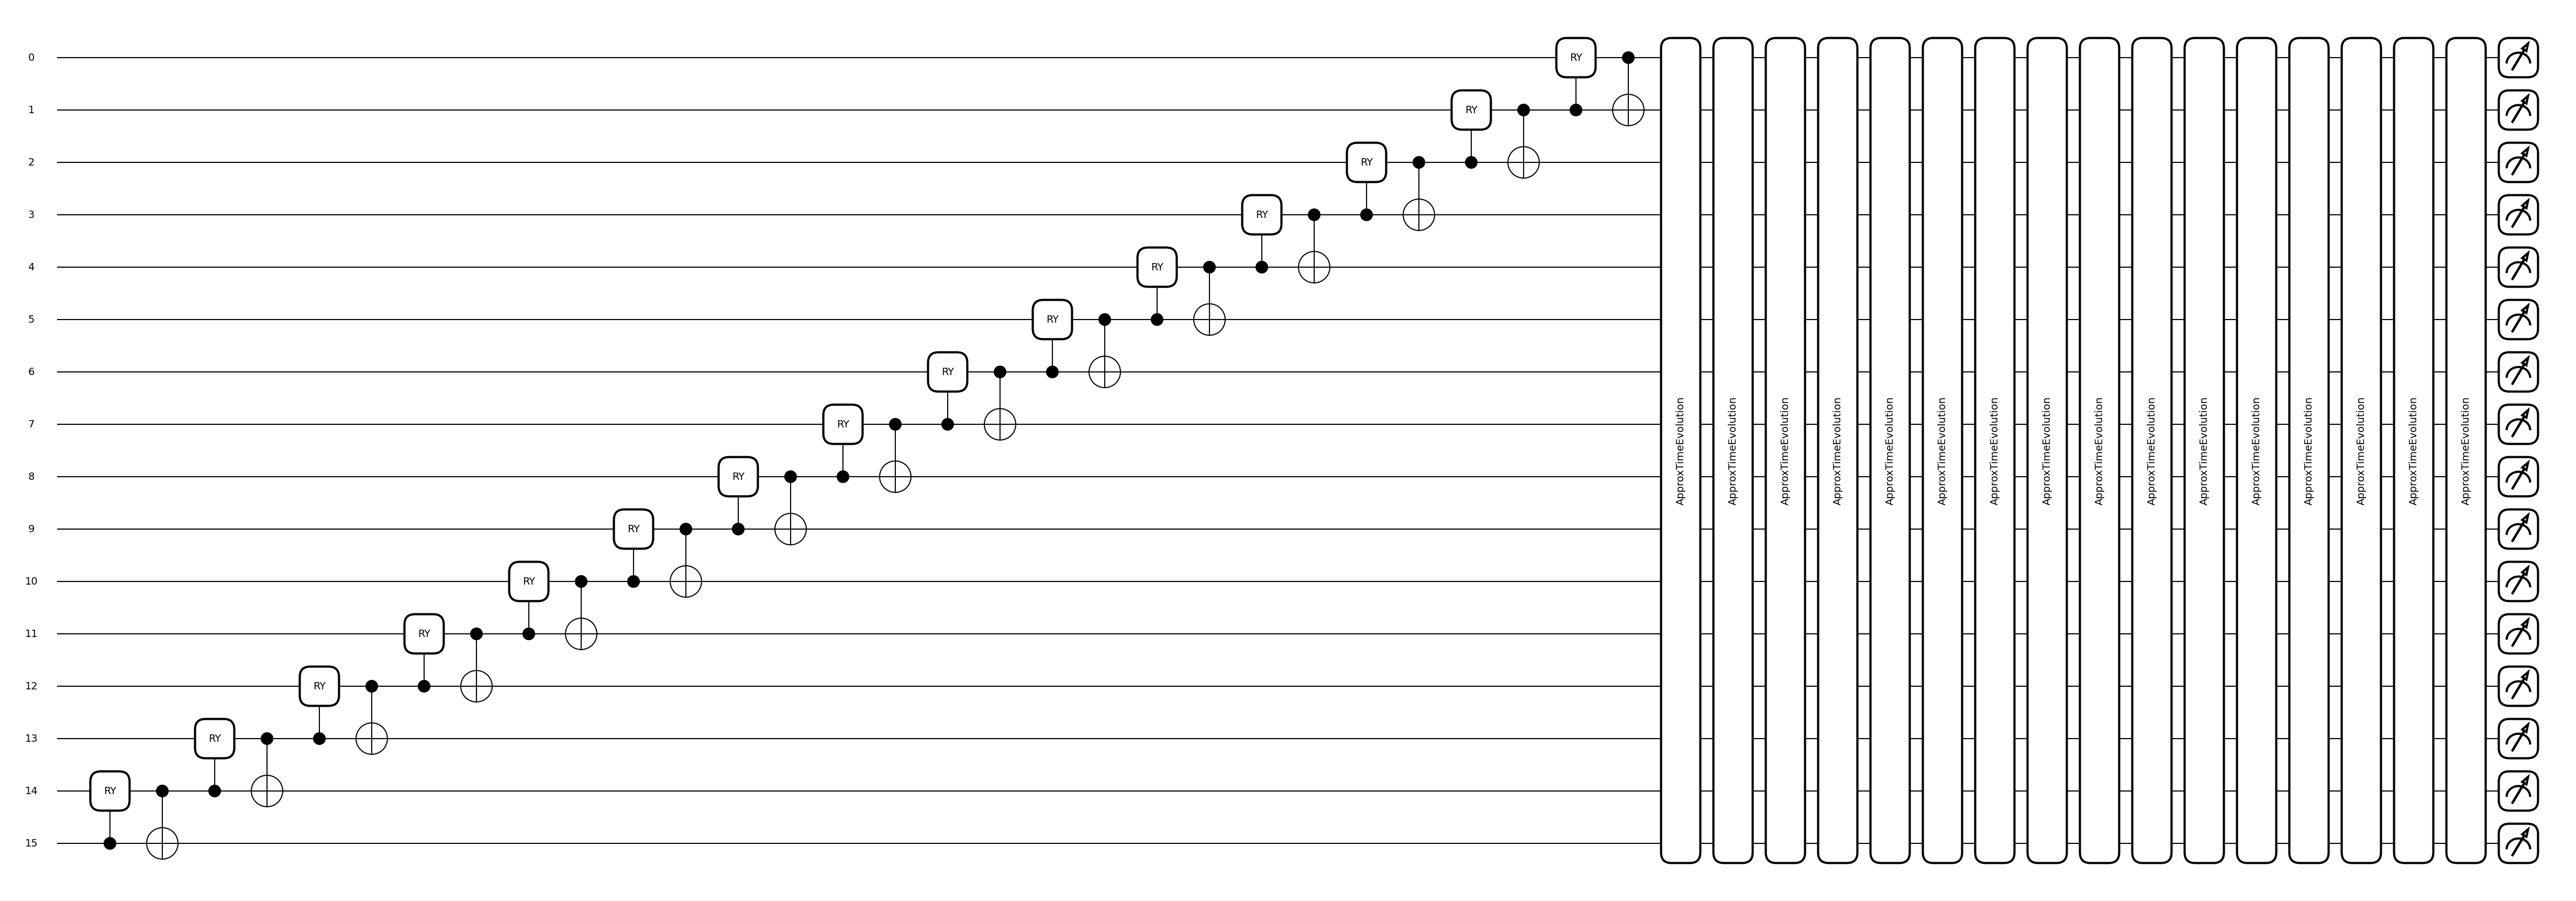

In [4]:
# TSP for fixed starting point
#  (scale=0. returns unscaled coefficients: only to show the large values!)
coeffs = tsp_generate_coeffs(gr, scale=0.)
pprint(coeffs)

# we want scaled coefficients (default: scale to 2*pi)
coeffs_scaled = tsp_generate_coeffs(gr)

nqubits = (gr.number_of_nodes()-1)**2
nlayers = 8
print(f"Number of qubits: {nqubits}; number of QAOA layers: {nlayers}")

# sampling mode? set nshots>0
nshots=0
# Define the device and the QAOA cost function
#dev = qml.device('default.qubit', wires=nqubits, shots=nshots)
#dev = qml.device("qulacs.simulator", wires=nqubits, shots=nshots)
#dev = qml.device("ionq.simulator", wires=nqubits, shots=1024, verbose=0)
dev = qml.device("lightning.qubit", wires=nqubits) #, shots=1)

# cost hamiltonian (must be defined outside of qml_qaoa_circuit)
cost_h = qml_general_cost_h(coeffs_scaled)

# (d) define cost function (QAOA circuit)
@qml.qnode(dev)
def cost_function(params, sample=0):
    qml_qaoa_circuit(params, cost_h, initial_state="W", nlayers=nlayers)
    if sample != 0:
        nshots = dev.shots.total_shots if hasattr(dev.shots, 'total_shots') else dev.shots
        if nshots is None: nshots = 0
        return qml.sample(wires=list(range(nqubits))) if sample*nshots>0 else qml.probs(wires=list(range(nqubits)))
    return qml.expval(cost_h)

# initialize parameters 
values = np.repeat(0.05, 2*nlayers).reshape(2, nlayers)
params = pnp.array(values, requires_grad=True)
print("Initial parameters:", params)

#print(qml.draw(cost_function, expansion_strategy="device")(params))
print(qml.draw_mpl(cost_function)(params))

Init params: [[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]]
  Max. Iterations=200  unless |diff(costs)|<0.1

Start of optimization loop: 2024-08-19 11:02:46.528244
Iteration 5: cost=-27.31 (cost diff=9.516)
Iteration 10: cost=-28.3167 (cost diff=0.5946)
Iteration 15: cost=-33.29 (cost diff=0.2386)
Iteration 20: cost=-36.2662 (cost diff=0.0578)
Iteration 25: cost=-36.1819 (cost diff=0.7047)
Iteration 30: cost=-34.5491 (cost diff=2.2746)
Iteration 35: cost=-37.9525 (cost diff=0.4132)
Iteration 40: cost=-39.3431 (cost diff=0.2968)
Iteration 45: cost=-39.8788 (cost diff=0.1722)
Iteration 50: cost=-40.691 (cost diff=0.2606)
Iteration 55: cost=-40.9216 (cost diff=0.0033)
Iteration 60: cost=-41.0649 (cost diff=0.2021)
Iteration 65: cost=-41.1766 (cost diff=0.1596)
Iteration 70: cost=-41.3499 (cost diff=0.1449)
Iteration 75: cost=-41.086 (cost diff=0.1967)
Iteration 80: cost=-41.2514 (cost diff=0.0404)
Early termination at iteration 80
End 

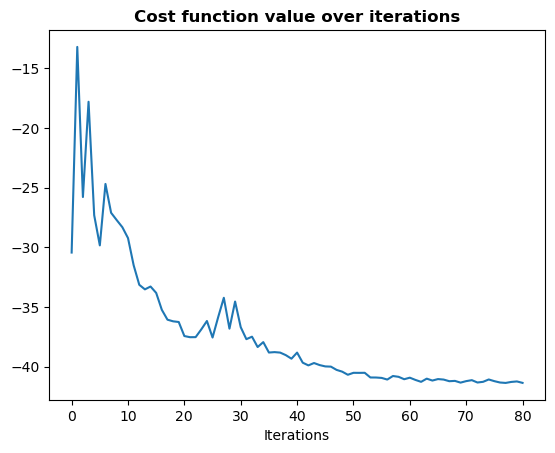

In [5]:
# define (classical) optimizer for QAOA parameters
#optimizer = qml.GradientDescentOptimizer()
#optimizer = qml.AdagradOptimizer(stepsize=0.5)
optimizer = qml.AdamOptimizer(stepsize=0.1)
#optimizer = qml.QNGOptimizer(stepsize=0.01, lam=0.001, approx="block-diag")
#optimizer = qml.QNSPSAOptimizer(stepsize=0.01, regularization=0.01)

# and run the optimization loop
params,costs = qml_qaoa_optimize(cost_function, optimizer, params, \
                                 max_iter=200, epsilon=0.1, printcycle=5)

# plot costs vs iteration
plot_histogram(costs, "costs")

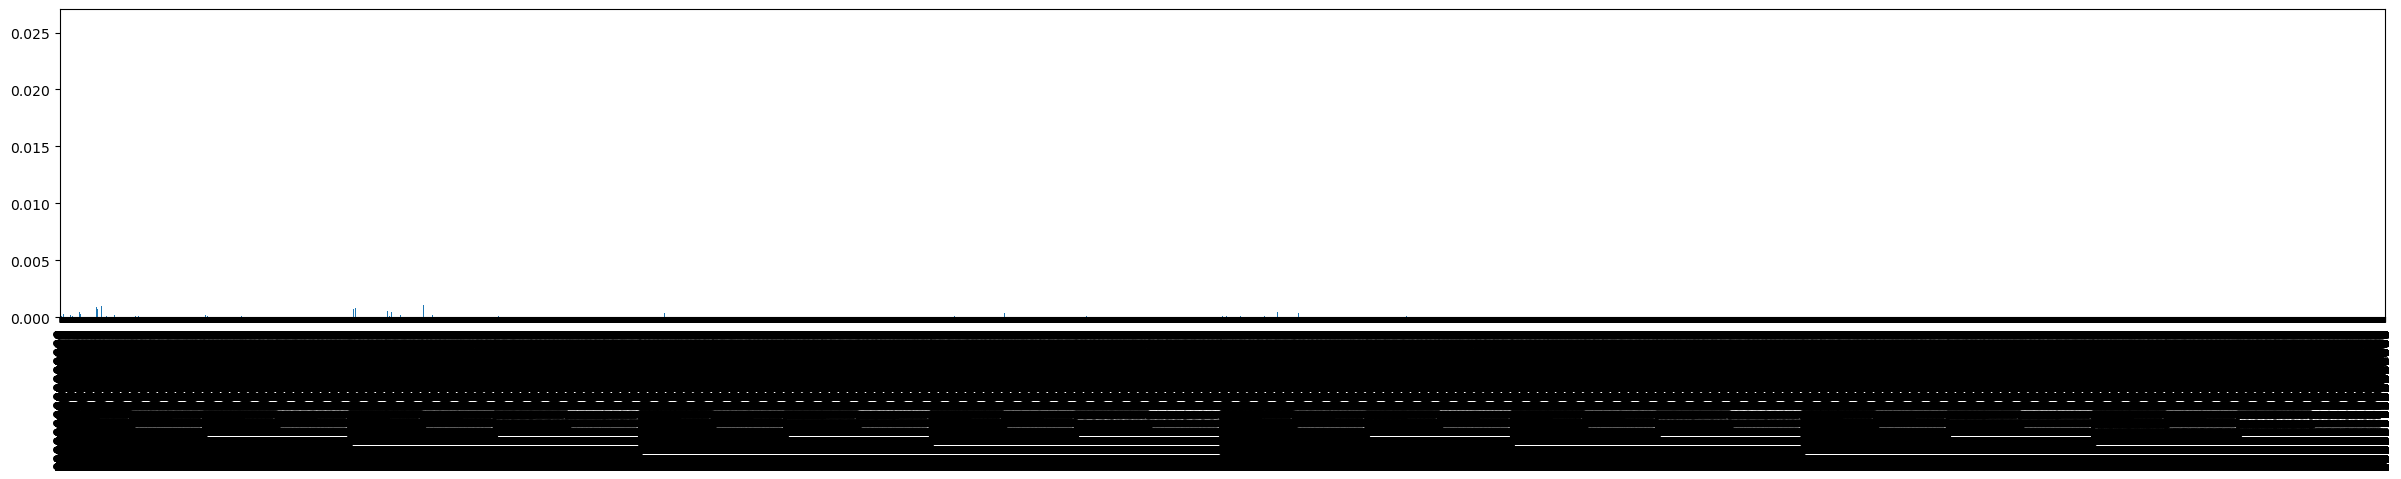

In [12]:
# to get probabilities and plot the distribution
probs = cost_function(params, sample=-1)
plot_probabilities(probs, figsize=(30,4))

In [6]:
probs = cost_function(params, sample=-1)
# plot most probable results
print(get_most_probable_states(probs, 10, tsp_matrix=0))
# and plot "good" results (where each city was visited) 
maxarr = get_most_probable_states(probs, 1000, tsp_matrix=2)
pprint(maxarr)

{'0010010000011000': 0.0089, '0010100000010100': 0.0088, '0100000100101000': 0.0088, '0001001001001000': 0.0088, '0010000101001000': 0.0088, '0001010000101000': 0.0087, '1000000100100100': 0.0087, '0010100001000001': 0.0087, '0001100000100100': 0.0087, '0010010010000001': 0.0087}
{'0001000100100100': [0.0003,
                      array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0]]),
                      [0, 4, 4, 3, 2]],
 '0001000100101000': [0.0002,
                      array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [1, 0, 0, 0]]),
                      [0, 4, 4, 3, 1]],
 '0001000100101100': [0.0021,
                      array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [1, 1, 0, 0]]),
                      [0, 4, 4, 3, 1]],
 '0001000101000010': [0.0003,
                      array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0]]),
                      [0, 4, 4, 2, 3]],
 '00010

[('04321', 0.014999999999999998),
 ('03241', 0.014899999999999998),
 ('04231', 0.014499999999999999),
 ('02431', 0.014399999999999998),
 ('03421', 0.014399999999999998),
 ('03124', 0.014099999999999996),
 ('03214', 0.013899999999999997),
 ('04312', 0.013899999999999997),
 ('03142', 0.013799999999999998),
 ('02143', 0.013599999999999998),
 ('04132', 0.013599999999999996),
 ('01432', 0.013299999999999996),
 ('03412', 0.013299999999999996),
 ('01243', 0.013199999999999996),
 ('04213', 0.013199999999999996),
 ('02341', 0.012799999999999997),
 ('02413', 0.012799999999999995),
 ('01342', 0.012699999999999996),
 ('04123', 0.012599999999999997),
 ('01324', 0.012499999999999997),
 ('02134', 0.012499999999999995),
 ('01423', 0.012399999999999996),
 ('02314', 0.012299999999999998),
 ('01234', 0.012199999999999997)]

solution: 04321   (prob. 0.015)


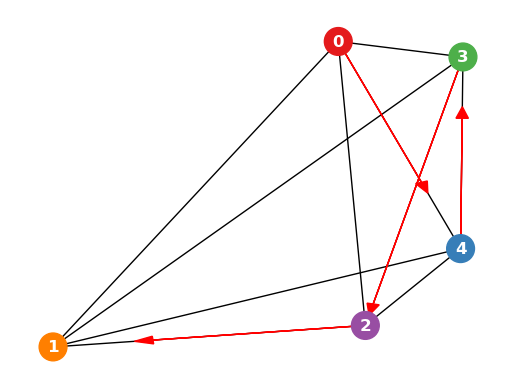


solution: 03241   (prob. 0.0149)


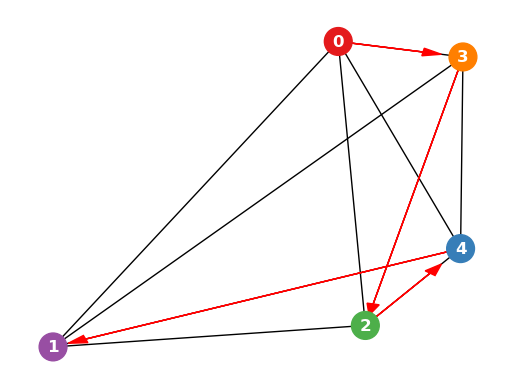


solution: 04231   (prob. 0.0145)


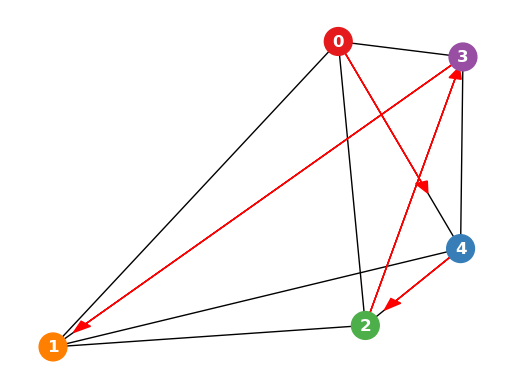


solution: 02431   (prob. 0.0144)


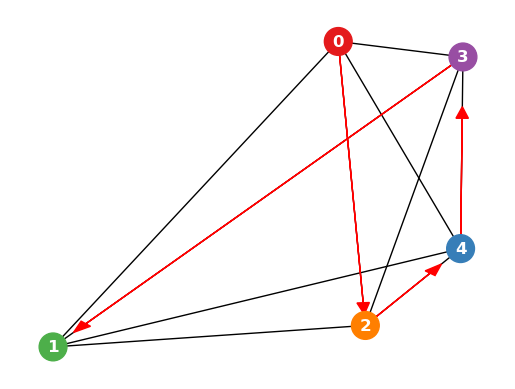

In [37]:
# display the most likely complete paths

from collections import defaultdict, OrderedDict

maxarr3 = get_most_probable_states(probs, 1000, tsp_matrix=3)

colordict = defaultdict(int)
for val in list(maxarr3.values()):
    mykey = "".join([ str(i) for i in val[2] ])
    colordict[mykey] += val[0]
sorted_colors = OrderedDict(sorted(colordict.items(), key=lambda item: item[1], reverse=True))
pprint(list(sorted_colors.items()))
for j,item in enumerate(list(sorted_colors.items())):
    print(f"\nsolution: {item[0]}   (prob. {round(item[1],5)})")
    cols = [ int(n) for n in list(item[0]) ]
    plot_graph(gr, colors=cols)
    if j > 2:
        break
   